In [2]:
import pandas as pd

# 모든 열(Columns) 다 보기
pd.set_option('display.max_columns', None)

# 모든 행(Rows) 다 보기
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)  # 또는 원하는 최대값


df = pd.read_csv("/data/ephemeral/home/work/python/upstageailab-nlp-summarization-nlp_3/data/raw/train.csv")

df.tail()

#df.value_counts('topic')
df['summary'].str.len().max()


# 1. 최대 길이 구하기
maxlen = df['summary'].str.len().max()

# 2. 최대 길이 row(혹은 여러 개)를 출력
max_rows = df[df['summary'].str.len() == maxlen]
max_rows

char_lengths = df['dialogue'].str.len()
print(f'최대 길이: {char_lengths.max()}')
print(f'평균 길이: {char_lengths.mean():.2f}')
print(f'중간값: {char_lengths.median()}')

char_lengths = df['summary'].str.len()
print(f'최대 길이: {char_lengths.max()}')
print(f'평균 길이: {char_lengths.mean():.2f}')
print(f'중간값: {char_lengths.median()}')

#dialogue: 2165, summary:376

최대 길이: 2165
평균 길이: 406.08
중간값: 369.0
최대 길이: 376
평균 길이: 85.79
중간값: 80.0


In [3]:

# ✅ 1. 기본 라이브러리 불러오기
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from transformers import AutoTokenizer

In [4]:
# ✅ 3. 데이터 로드 (src/data)
train_path = r"/data/ephemeral/home/work/python/upstageailab-nlp-summarization-nlp_3/data/raw/train.csv"
test_path = r"/data/ephemeral/home/work/python/upstageailab-nlp-summarization-nlp_3/data/raw/test.csv"

train = pd.read_csv(train_path, encoding="utf-8")  # or cp949 if needed
test = pd.read_csv(test_path, encoding="utf-8")

In [5]:
# ✅ 4. 기본 정보 확인
print("✅ train.csv shape:", train.shape)
print("✅ test.csv shape:", test.shape)
print("\n📌 train 컬럼 목록:", train.columns.tolist())
print("\n📌 train 샘플:\n", train.head())


✅ train.csv shape: (12457, 4)
✅ test.csv shape: (499, 2)

📌 train 컬럼 목록: ['fname', 'dialogue', 'summary', 'topic']

📌 train 샘플:
      fname  \
0  train_0   
1  train_1   
2  train_2   
3  train_3   
4  train_4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    dialogue  \
0  #Person1#: 안녕하세요, Mr. Smith. 저는 Dr. Hawkins입니다. 오늘 무슨 일로 오셨어요? \n#Person2#: 건강검진을 받으려고 왔어요. \n#Person1#: 네, 5년 동안 검진을 안 받으셨네요. 매년 한 번씩 받으셔야 해요. \n#Person2#: 알죠. 특별히 아픈 데가 없으면 굳이 갈 필요가 없다고 생각했어요. \n#Person1#: 음, 심각한 질병을 피하려면

In [6]:
# ✅ 5. 결측치 & 중복 확인
print("\n📌 결측치:\n", train.isnull().sum())
print("\n📌 중복 행 개수:", train.duplicated().sum())



📌 결측치:
 fname       0
dialogue    0
summary     0
topic       0
dtype: int64

📌 중복 행 개수: 0


In [7]:
# ✅ 6. 텍스트 길이 통계 분석
train['text_length'] = train['dialogue'].apply(len)
print("\n📌 text 길이 통계:\n", train['text_length'].describe())

print("📌 토픽별 샘플 텍스트 (최대 5개까지 출력):")
unique_topics = sorted(train["topic"].unique())[:5]  # 너무 많으면 제한

for topic in unique_topics:
    sample_text = train[train["topic"] == topic]["dialogue"].values[0][:300]
    print(f"\n🟡 [Topic: {topic}] 샘플 텍스트 (앞 300자):\n{sample_text}")



📌 text 길이 통계:
 count    12457.000000
mean       406.083487
std        197.566083
min         84.000000
25%        280.000000
50%        369.000000
75%        500.000000
max       2165.000000
Name: text_length, dtype: float64
📌 토픽별 샘플 텍스트 (최대 5개까지 출력):

🟡 [Topic: 'The Power of One' 책 읽기] 샘플 텍스트 (앞 300자):
#Person1#: 무슨 책 읽고 있어? 어젯밤부터 그 책에서 눈을 떼지 않더라.
#Person2#: 이 책 정말 재밌어. 도저히 손에서 뗄 수가 없어! 'The Power of One'이라고 해.
#Person1#: 나도 그렇게 재밌는 책 읽은 지 오래됐어.
#Person2#: 나도 그래. 첫 페이지부터 이 작가가 날 확 끌어들이더라고!
#Person1#: 네가 다 읽고 나면 나도 볼 수 있어?
#Person2#: 응, 지금 막 마지막 장 읽고 있는데 진짜 손에 땀을 쥐게 돼.
#Person1#: 아무 얘기도 하지 마. 나 혼자 

🟡 [Topic: 100만 달러 사용 계획] 샘플 텍스트 (앞 300자):
#Person1#: 너 만약에 100만 달러 받으면 뭐 할 거야?
#Person2#: 음, 잘 모르겠어. 아마 차를 사지 않을까?
#Person1#: 그거 좀 재미없어 보이는데.
#Person2#: 그럼 넌 뭐 할 건데?
#Person1#: 난 세계 일주 여행 갈 거야.
#Person2#: 어디로 갈 건데?
#Person1#: 첫 번째로 파리에 갈 거야. 파리에서 쇼핑하는 게 늘 꿈이었거든.
#Person2#: 좋은 생각이네. 거기서 돈 좀 쓰면 되겠다.
#Person1#: 응, 그리고 나서 로마에 갈 거야. 내가 이탈리아 음식을 

🟡 [Topic: 13일 금요일 미신] 샘플 텍스트 (앞 300자):
#Person1#

In [8]:
# ✅ 7. 스페셜 토큰
import re
import ast

def reg_masking(text):
  pattern = r"#\w+#"  # ## 사이의 값을 추출하는 정규식 패턴
  masked = re.findall(pattern, text)
  return masked

train_set = train['dialogue'].apply(lambda x:str(set(reg_masking(x))))
set_train = train_set.apply(ast.literal_eval)

test_set = test['dialogue'].apply(lambda x:str(set(reg_masking(x))))
set_test = test_set.apply(ast.literal_eval)


# 모든 set을 하나로 합치기
all_elements =  set().union(*set_train).union(*set_test)
print(all_elements)


{'#CardNumber#', '#Person2#', '#Alex#', '#SSN#', '#Address#', '#PhoneNumber#', '#Person7#', '#Email#', '#Kristin#', '#CarNumber#', '#PersonName#', '#DateOfBirth#', '#Person6#', '#Person1#', '#Person5#', '#Name#', '#Person3#', '#PassportNumber#', '#Liliana#', '#Person4#', '#Price#', '#Bob#'}


In [34]:
from transformers import AutoTokenizer

# KoBART 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained("gogamza/kobart-base-v2")

def getTokenSize(text):

    # 토큰화 후 토큰 수 계산
    tokens = tokenizer(text)
    token_count = len(tokens['input_ids'])

    if(token_count > 1000):
        print("*"*20)
        print(f"토큰 수: {token_count}")
        print(f"text: {text}")
        print("*"*20)

    return token_count  

train['dialogue'].apply(getTokenSize)        

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


********************
토큰 수: 1068
text: #Person1#: 안녕하세요, 저희 새 프로그램 Exotic Animal Kingdom에 오신 걸 환영합니다. 이 프로그램은 어린이와 어른 모두에게 동물을 소개하는 겁니다. 오늘의 쇼에서는 젊지만 경력을 가진 게스트가 수염용 드래곤의 놀라운 세계를 소개해 줄 거에요. 환영합니다, Joshua. 정말 감사합니다. Joshua, 솔직히 말해서, 수염용 드래곤이라는 이름이 뭔가 판타지 책에서 나올 것 같아요. 수염용 드래곤이 정확히 어떤 건가요?  
#Person2#: 여기 Bert를 한번 잡아보시는 게 어때요?  
#Person1#: 오... 와우! 제가 설명하는 동안요. 네 
#Person2#: 수염용 드래곤은 사실 호주의 사막에서 유래했습니다. 이 종은 그 기후에서 살아남은 여러 종 중 하나입니다. 오늘날, 이 수염용 드래곤들은 미국에서 가정에서 사육되고 있습니다. 
#Person3#: 그렇군요. 그러면 수염용 드래곤을 키울 때 알아야 할 필수적인 것들은 무엇인가요? 가족 애완동물로 키울 수 있나요?  
#Person2#: 수염용 드래곤은 가족 애완동물로 아주 좋고 매우 온순한 동물입니다. 
#Person1#: 네, 이 아이도 꽤 친근해 보이네요. 
#Person2#: 그냥 어떻게 돌보는지 알면 돼요. 
#Person1#: 어떤 점들을 염두에 둬야 하나요? 
#Person2#: 먼저, 적절한 용품을 준비해야 합니다: 일종의 거처... 
#Person1#: 예를 들면, 우리 같은 것요. 
#Person2#: 네. 전 스펙트럼 형광등과 쪼임 램프, 그리고 오르고 머무르기에 적당한 가지와 바위, 물과 음식을 담을 그릇, 우리 바닥을 덮을 무언가가 필요합니다. 
#Person1#: 기본적인 것들을 알아볼까요. 수염용 드래곤의 식단은 어떤가요? 육식동물 같아 보여요... 혹시 매운 멕시코 타코 같은 건 먹나요? 
#Person4#: 아니요, 수염용 드래곤은 잡식성이에요... 
#Person1#: 잡식

0         281
1         225
2         153
3         164
4         150
5          94
6          89
7         357
8         134
9         157
10        293
11        193
12        118
13        189
14        348
15         78
16         90
17        160
18        167
19        120
20        152
21        175
22        249
23        133
24        201
25        292
26        167
27        180
28        199
29        149
30        182
31        232
32         83
33        319
34        279
35        375
36        216
37        262
38        173
39        253
40        194
41        122
42        187
43        163
44        156
45        240
46        117
47        190
48        191
49        125
50        296
51         77
52        245
53         67
54        193
55        259
56         65
57        146
58        458
59        107
60        131
61        192
62        236
63        420
64        256
65        146
66        160
67        165
68        165
69        305
70        255
71    

In [33]:
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

# 모델과 토크나이저 로드
tokenizer = PreTrainedTokenizerFast.from_pretrained('EbanLee/kobart-summary-v3')
model = BartForConditionalGeneration.from_pretrained('EbanLee/kobart-summary-v3')

def summarize_dialogue(text, max_length=150):
    # 입력 길이가 1024를 초과하면 자동으로 잘림
    inputs = tokenizer(text, 
                      return_tensors="pt", 
                      max_length=1024, 
                      truncation=True)
    
    # 요약 생성
    summary_ids = model.generate(inputs['input_ids'],
                                num_beams=4,
                                max_length=max_length,
                                early_stopping=True)
    
    # 디코딩
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# 사용
dialogue = """#Person1#: 안녕, Andrew! 안녕 ...? Andrew. 
#Person2#: 뭐? 
#Person1#: Andrew. 
#Person2#: 뭐? 무슨 일이야? 
#Person1#: 너한테 무슨 일이야? 
#Person2#: 내 머리 얘기하는 거야? 내 머리 마음에 들어? 
#Person1#: 어, 무슨 말인지 알잖아, Andrew. 솔직하게 말할까? 
#Person2#: 뭐? 
#Person1#: 좋아. Andrew, 너 크리스마스 때 본 이후로 엄청 쪘어. 무슨 일이 있었던 거야? 
#Person2#: 너 왜 항상 그렇게 솔직해? 
#Person1#: 난 누나잖아. 내가 ... 뭐야? 너보다 세 살 많으니까 말하고 싶으면 솔직할 수 있어. 게다가, 너 항상 나한테 그런 말 하곤 했잖아. 나 어릴 때 너 나한테 뚱뚱하다고 그랬잖아. 
#Person2#: 아, 그래, 솔직히 말해서, 응, 어제부터 삶을 바꾸기 시작했어. 
#Person1#: 오, 잘됐네! 
#Person2#: 나 와후 다이어트 중이야. 
#Person1#: 뭐? 와후 다이어트가 뭐야? 
#Person2#: 아, 설명하기 너무 복잡해. 며칠 전에 스팸메일에서 정보 찾았거든 ... 
#Person1#: 뭐? 스팸메일을 읽어? 아무도 스팸메일 안 읽잖아. 
#Person2#: ... 그리고 등록했거든, 490달러밖에 안 들었어. 
#Person1#: 진심이야? 
#Person2#: 응. 
#Person1#: 490달러씩? 매달이야 아니면 매주야? 
#Person2#: 아, 그건 확인 안 해봤는데 ... 하지만, 하지만, 하지만 ... 그런 것 같아. 
#Person1#: 잘 들어, 너 사기당하는 것 같아, 그거 진짜로 이상해. 나 뚱뚱하지 않으니까 믿어. ... 체중 감량하고 싶으면 제대로 해야 돼. 
#Person2#: 그럼, 어떻게? 
#Person1#: 좋아, 오케이. 
#Person2#: 봐봐, 내 운동화 저기 있잖아. 
#Person1#: Andrew. 아직 박스에 그대로네. 
#Person2#: 그게 ... 
#Person1#: 한 번도 안 신었네. 운동을 해야 해, 운동은 좋아. 근데 제대로 먹는 법도 배워야 해. 예를 들어, 적당한 양을 먹어야 해. 그리고 가족 모임에서 항상 하던 것처럼 두 접시 세 접시 먹으면 안 돼. 
#Person2#: 그럼, 큰 접시 써야겠네! 
#Person1#: Andrew! 그건 안돼. 다음. 
#Person2#: 다음? 
#Person1#: 첫째로 적은 양을 먹어야 해 
#Person2#: 오케이. 
#Person1#: 아침에 균형 잡힌 아침 식사를 해야 해 
#Person2#: 그건 해. 
#Person1#: 그리고 그다음에 작은 식사를 하루 종일 해야지. 아침을 안 먹으면 점심이나 저녁에 과식하게 되잖아. 
#Person2#: 음 ... 
#Person1#: 그리고 밤늦게 먹지 마. 
#Person2#: 뭐? 뭐같이? 
#Person1#: 많은 사람들이 늦은 밤에 간식을 먹고 싶어 하는데, 그게 대부분 칼로리가 많은 것들이야. 아이스크림 같은 거, 활동을 안 해서 그걸 살로 저장하거든. 버려야 해 ... 오 마이 갓! 
#Person2#: 뭐? 
#Person1#: 너 냉동실에 아이스크림밖에 없어! 다 버려야 해? 
#Person2#: 그건 저칼로리 아이스크림이야. 
#Person1#: 저칼 ... 아니야, 저칼로리가 아냐. 여기 봐봐. Andrew! 너 먹는 게 아이스크림밖에 없네. 
#Person2#: 그럼 뭐, 뭐? 
#Person1#: 또 다른 건 뭐 먹어? 
#Person2#: 글쎄 ... 
#Person1#: 진짜로? 아이스크림만 먹어? 아, 아, 아. 쓰레기통 봐봐. 매일 맥도날드 가네. 매일 패스트푸드 먹는다고? 
#Person2#: 그게 ... 
#Person1#: 패스트푸드 줄여야 해. 맥도날드 매니저 이름을 알 정도고, 페이스북에서 베프라면, 패스트푸드를 너무 많이 먹는 거야. 
#Person2#: 이거 진짜 힘들겠는데. 
#Person1#: 그래, 그럴 거야. 근데 과일과 채소를 많이 먹어야 해. 
#Person2#: 아, 그래. 
#Person1#: 설탕을 확 줄여야 해. 매일 다섯 갤런씩 마시는 콜라 같은 달달한 음료 안 돼. 
#Person2#: 다섯 갤런 안 마셔. 
#Person1#: 그럼 그 컵 사이즈 좀 봐. 몇 번이나 리필해? 
#Person2#: 그럼 마실 게 뭐야? 
#Person1#: 물! 
#Person2#: 물? 
#Person1#: 정말 몸에 좋아. 
#Person2#: 아, 이거 힘들겠어. 
#Person1#: 어쩌면 힘들지."""

summary = summarize_dialogue(dialogue)
print(f"요약: {summary}")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels will be overwritten to 2.


요약: 많은 사람들이 늦은 밤에 간식을 먹고 싶어 하는데, 그게 대부분 칼로리가 많은 것들이야. 아이스크림 같은 거, 활동을 안 해서 그걸 살로 저장하거든. 버려야 해요. 


/tmp/ipykernel_1157072/1358090593.py:7: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1157072/1358090593.py:7: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1157072/1358090593.py:7: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1157072/1358090593.py:7: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1157072/1358090593.py:7: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1157072/1358090593.py:7: UserWarning: Glyph 53581 (\N{HANGUL SYLLABLE TEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1157072/1358090593.py:7: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.

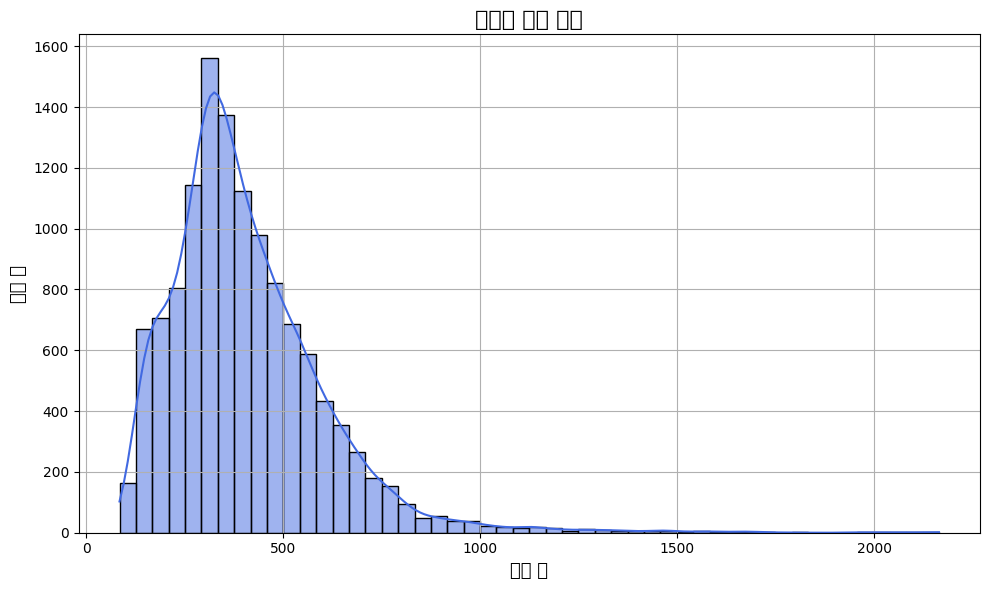

In [26]:

# ✅ 1. 텍스트 길이 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train['text_length'], bins=50, kde=True, color='royalblue')
plt.title("텍스트 길이 분포", fontsize=16)
plt.xlabel("문자 수", fontsize=13)
plt.ylabel("샘플 수", fontsize=13)
plt.tight_layout()
plt.grid(True)
plt.show()

In [35]:
def context_aware_removal(text):
    """문맥을 고려한 태그 처리"""
    
    # HTML 태그 특징: 소문자, 알려진 태그명
    html_pattern = r'<(div|p|span|a|img|br|hr|h[1-6]|ul|ol|li|table|tr|td|strong|b|em|i)[^>]*>'
    text = re.sub(html_pattern, '', text, flags=re.IGNORECASE)
    
    # 닫는 태그
    text = re.sub(r'</(div|p|span|a|h[1-6]|ul|ol|li|table|tr|td|strong|b|em|i)>', '', text, flags=re.IGNORECASE)
    
    # 화자 태그는 그대로 두거나 변환
    # <이름> 패턴을 이름: 으로 변환
    text = re.sub(r'<([A-Za-z가-힣\s]+)>', r'\1:', text)
    
    return text


test_cases = [
    "<The Witch> 마법을 사용합니다",
    "<Player1> 안녕하세요",
    "<div class='content'>HTML 내용</div>",
    "<p>문단입니다</p>", 
    "<a href='link'>링크</a>",
    "<System> 시스템 메시지",
    "<br>",
    "<img src='image.jpg'>",
    "<span>텍스트</span>"
]

print("컨텍스트 기반 처리 결과:")
for text in test_cases:
    result = context_aware_removal(text)
    print(f"'{text}' → '{result}'")

컨텍스트 기반 처리 결과:
'<The Witch> 마법을 사용합니다' → 'The Witch: 마법을 사용합니다'
'<Player1> 안녕하세요' → ' 안녕하세요'
'<div class='content'>HTML 내용</div>' → 'HTML 내용'
'<p>문단입니다</p>' → '문단입니다'
'<a href='link'>링크</a>' → '링크'
'<System> 시스템 메시지' → 'System: 시스템 메시지'
'<br>' → ''
'<img src='image.jpg'>' → ''
'<span>텍스트</span>' → '텍스트'


In [38]:
def find_all_repetitions(text):
    """실제로 매치되는 전체 문자열 확인"""
    #pattern = r'(.)\1{2,}'
    pattern = r'([^\d])\1{2,}'
    
    # finditer로 매치 위치와 내용 모두 확인
    matches = list(re.finditer(pattern, text))
    
    print(f"총 {len(matches)}개의 반복 패턴 발견:")
    for i, match in enumerate(matches):
        start, end = match.span()
        matched_text = text[start:end]
        repeated_char = match.group(1)
        
        print(f"{i+1}. '{matched_text}' (위치: {start}-{end}, 문자: '{repeated_char}')")
    
    return matches


test['dialogue'].apply(find_all_repetitions)     

총 2개의 반복 패턴 발견:
1. '...' (위치: 60-63, 문자: '.')
2. '...' (위치: 164-167, 문자: '.')
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 1개의 반복 패턴 발견:
1. '...' (위치: 280-283, 문자: '.')
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 2개의 반복 패턴 발견:
1. '...' (위치: 155-158, 문자: '.')
2. '...' (위치: 308-311, 문자: '.')
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 2개의 반복 패턴 발견:
1. '...' (위치: 320-323, 문자: '.')
2. '...' (위치: 326-329, 문자: '.')
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 3개의 반복 패턴 발견:
1. '...' (위치: 205-208, 문자: '.')
2. '...' (위치: 245-248, 문자: '.')
3. '...' (위치: 281-284, 문자: '.')
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 2개의 반복 패턴 발견:
1. '...' (위치: 61-64, 문자: '.')
2. '...' (위치: 160-163, 문자: '.')
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 발견:
총 0개의 반복 패턴 

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             [<re.Match object; span=(60, 63), match='...'>, <re.Match object; span=(164, 167), match='...'>]
1                                                                                                                                                                                                                                                                                                                                                        

In [ ]:

# ✅ 1. 텍스트 길이 분포 시각화
plt.figure(figsize=(10, 6))
sns.histplot(train['text_length'], bins=50, kde=True, color='royalblue')
plt.title("텍스트 길이 분포", fontsize=16)
plt.xlabel("문자 수", fontsize=13)
plt.ylabel("샘플 수", fontsize=13)
plt.tight_layout()
plt.grid(True)
plt.show()

# ✅ 2. 요약 텍스트 길이 분포 (summary)
train['summary_len'] = train['summary'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train['summary_len'], bins=50, kde=True, color='salmon')
plt.title("요약 텍스트 길이 분포")
plt.xlabel("문자 수")
plt.ylabel("샘플 수")
plt.tight_layout()
plt.savefig("summary_length_distribution.png", dpi=200)
plt.close()

# ✅ 3. 레이블 분포 (상위 100개)
top_topics = train['topic'].value_counts().nlargest(100)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_topics.index, y=top_topics.values, palette="Set3")
plt.title("Topic 상위 100개 분포")
plt.xticks(rotation=75)
plt.tight_layout()
plt.savefig("top100_topic_distribution.png", dpi=200)
plt.close()

# ✅ 4. 고유 토픽 개수 출력
print("고유 Topic 개수:", train['topic'].nunique())

# ✅ 5. 특수문자/숫자 포함 비율
import re

def count_special_ratio(text):
    return len(re.findall(r"[^\w\s]", text)) / len(text)

train['special_ratio'] = train['dialogue'].apply(count_special_ratio)
print("평균 특수문자 비율:", train['special_ratio'].mean())

# ✅ 6. tokenizer 기준 토큰 길이
tokenizer = AutoTokenizer.from_pretrained("hyunwoongko/kobart") # 요약 task에 적합
train['dialogue_token_len'] = train['dialogue'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))
train['summary_token_len'] = train['summary'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))

plt.figure(figsize=(10, 5))
sns.histplot(train['dialogue_token_len'], color="dodgerblue", label="입력")
sns.histplot(train['summary_token_len'], color="tomato", label="요약")
plt.title("Token 길이 분포")
plt.xlabel("Token 수")
plt.legend()
plt.tight_layout()
plt.savefig("token_length_comparison.png", dpi=200)
plt.close()

# 요약 vs 입력 길이 비율 분포
# → 평균값이 너무 높거나 낮으면 모델이 잘 못 배움
#→ 보통 3~8 사이 분포가 안정적
train['dialogue_len'] = train['dialogue'].apply(len)
train['summary_len'] = train['summary'].apply(len)
train['length_ratio'] = train['dialogue_len'] / train['summary_len']

plt.figure(figsize=(10, 6))
sns.histplot(train['length_ratio'], bins=50, kde=True, color="purple")
plt.title("입력 길이 / 요약 길이 비율 분포", fontsize=16)
plt.xlabel("비율 (dialogue / summary)")
plt.ylabel("샘플 수")
plt.tight_layout()
plt.savefig("dialogue_summary_ratio.png", dpi=200)
plt.close()

# tokenizer 적용 후 입력/요약 토큰 수
# → max_seq_len, max_target_len 설정 근거가 됨
# → ex) 95% quantile 기준으로 자르는 게 좋음
tokenizer = AutoTokenizer.from_pretrained("hyunwoongko/kobart")

train['input_token_len'] = train['dialogue'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))
train['output_token_len'] = train['summary'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))

plt.figure(figsize=(10, 6))
sns.histplot(train['input_token_len'], color="dodgerblue", label="입력", kde=True)
sns.histplot(train['output_token_len'], color="tomato", label="요약", kde=True)
plt.title("Token 길이 분포 (tokenizer 적용 후)", fontsize=16)
plt.xlabel("토큰 수")
plt.legend()
plt.tight_layout()
plt.savefig("token_length_distribution.png", dpi=200)
plt.close()

# topic별 요약 길이 차이 확인
plt.figure(figsize=(14, 6))
sns.boxplot(x='topic', y='summary_len', data=train[train['topic'].isin(train['topic'].value_counts().nlargest(10).index)])
plt.title("상위 10개 Topic별 요약 길이 분포", fontsize=16)
plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig("summary_length_per_topic.png", dpi=200)
plt.close()

# 중복 대화 탐지
duplicate_dialogues = train['dialogue'].duplicated().sum()
print(f"📌 중복된 dialogue 수: {duplicate_dialogues}개 ({duplicate_dialogues/train.shape[0]*100:.2f}%)")

In [24]:
import pandas as pd

# 모든 열(Columns) 다 보기
pd.set_option('display.max_columns', None)

# 모든 행(Rows) 다 보기
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)  # 또는 원하는 최대값

df.topic.unique()

array(['건강검진', '백신 접종', '열쇠 분실', ..., '작문 작성', '호텔 안내', '실직과 대처'],
      shape=(9235,), dtype=object)